In [61]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

from datetime import timedelta

from sklearn.model_selection import TimeSeriesSplit

# Load and check data

In [62]:
PROCESSED_DATA_FOLDER = "data/4_all_data_preprocessed"
DATASET_FILE = "all_features"

In [63]:
# Load dataset
dataset = pickle.load(open(f"{PROCESSED_DATA_FOLDER}/{DATASET_FILE}.pkl", "rb"))

In [64]:
# Check the size of the data
dataset.shape

(192867, 760)

In [65]:
# Check preview the dataset
dataset.head()

,event_indicator,city_resolvedAddress,day_datetime,isw_date_tomorrow_datetime,day_tempmax,day_tempmin,day_temp,day_dew,day_humidity,day_precip,...,isw_work,isw_would,isw_wound,isw_year,isw_yet,isw_yevgeni,isw_zaporizhia,isw_zaporizhzhia,isw_znpp,isw_zone
0,False,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,-0.914859,-0.891013,-1.005704,-0.859391,0.463837,-0.150888,...,-0.572789,-0.900938,-0.484874,-0.454756,6.697784,-0.370716,-1.173598,-0.536879,-0.464022,-0.456176
1,False,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,-0.914859,-0.891013,-1.005704,-0.859391,0.463837,-0.150888,...,-0.572789,-0.900938,-0.484874,-0.454756,6.697784,-0.370716,-1.173598,-0.536879,-0.464022,-0.456176
2,False,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,-0.914859,-0.891013,-1.005704,-0.859391,0.463837,-0.150888,...,-0.572789,-0.900938,-0.484874,-0.454756,6.697784,-0.370716,-1.173598,-0.536879,-0.464022,-0.456176
3,False,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,-0.914859,-0.891013,-1.005704,-0.859391,0.463837,-0.150888,...,-0.572789,-0.900938,-0.484874,-0.454756,6.697784,-0.370716,-1.173598,-0.536879,-0.464022,-0.456176
4,False,"Луцьк, Луцький район, Україна",2022-02-25,2022-02-25,-0.914859,-0.891013,-1.005704,-0.859391,0.463837,-0.150888,...,-0.572789,-0.900938,-0.484874,-0.454756,6.697784,-0.370716,-1.173598,-0.536879,-0.464022,-0.456176


In [66]:
# Check summary of dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192867 entries, 0 to 192866
Columns: 760 entries, event_indicator to isw_zone
dtypes: bool(1), float64(756), object(3)
memory usage: 1.1+ GB


In [67]:
dataset.dtypes

event_indicator                  bool
city_resolvedAddress           object
day_datetime                   object
isw_date_tomorrow_datetime     object
day_tempmax                   float64
                               ...   
isw_yevgeni                   float64
isw_zaporizhia                float64
isw_zaporizhzhia              float64
isw_znpp                      float64
isw_zone                      float64
Length: 760, dtype: object

In [68]:
# Check nan
dataset.isna().sum()

event_indicator               0
city_resolvedAddress          0
day_datetime                  0
isw_date_tomorrow_datetime    0
day_tempmax                   0
                             ..
isw_yevgeni                   0
isw_zaporizhia                0
isw_zaporizhzhia              0
isw_znpp                      0
isw_zone                      0
Length: 760, dtype: int64

In [69]:
# Sort dataset by date
dataset['day_datetime'] = pd.to_datetime(dataset['day_datetime'])
dataset = dataset.sort_values(by='day_datetime')
dataset.day_datetime.describe(datetime_is_numeric=True)

count                           192867
mean     2022-08-02 23:32:38.163916288
min                2022-02-25 00:00:00
25%                2022-05-10 00:00:00
50%                2022-08-02 00:00:00
75%                2022-10-24 00:00:00
max                2023-01-20 00:00:00
Name: day_datetime, dtype: object

In [70]:
# Extract relevant date features
dataset['year'] = dataset['day_datetime'].dt.year
dataset['month'] = dataset['day_datetime'].dt.month
dataset['day'] = dataset['day_datetime'].dt.day
dataset['day_of_week'] = dataset['day_datetime'].dt.dayofweek

dataset['season'] = (dataset['day_datetime'].dt.month % 12 // 3).replace({0: 'winter', 1: 'spring', 2: 'summer', 3: 'fall'})

dataset = pd.get_dummies(dataset, columns=['season'])

In [71]:
# Translate city names
dataset.rename(columns = {'city_resolvedAddress':'city'}, inplace=True)
dataset['city'].unique()

array(['Луцьк, Луцький район, Україна', 'Житомир, Україна',
       'Рівне, Україна', 'Полтава, Україна', 'Тернопіль, Україна',
       'Ужгород, Ужгородський район, Україна', 'Донецьк, Україна',
       'Запоріжжя, Україна', 'Суми, Україна', 'Черкаси, Україна',
       'Вінниця, Україна', 'Львів, Україна', 'Івано-Франківськ, Україна',
       'Херсон, Україна', 'Київ, Україна', 'Дніпро, Україна',
       'Чернівці, Україна', 'Кропивницький, Україна', 'Харків, Україна',
       'Миколаїв, Україна', 'Хмельницька область, Україна',
       'Одеса, Україна', 'Чернігів, Україна'], dtype=object)

In [72]:
region_dict = {
    "Київ, Україна" : 'Kyiv', 
    "Миколаїв, Україна" : 'Mykolaiv',
    "Дніпро, Україна": 'Dnipro',
    "Харків, Україна" : 'Kharkiv', 
    "Житомир, Україна": 'Zhytomyr',
    "Кропивницький, Україна": 'Kropyvnytskyi',
    "Запоріжжя, Україна": 'Zaporizhzhia',
    "Полтава, Україна": 'Poltava',
    "Чернігів, Україна": 'Chernihiv',
    "Одеса, Україна": 'Odesa',
    "Хмельницька область, Україна": 'Khmelnytskyi',
    "Черкаси, Україна": 'Cherkasy',
    "Суми, Україна": 'Sumy',
    "Вінниця, Україна": 'Vinnytsia',
    "Херсон, Україна": 'Kherson',
    "Львів, Україна": 'Lviv',
    "Луцьк, Луцький район, Україна": 'Lutsk',
    "Рівне, Україна": 'Rivne',
    "Івано-Франківськ, Україна": 'Ivano-Frankivsk',
    "Тернопіль, Україна": 'Ternopil',
    "Чернівці, Україна": 'Chernivtsi',
    "Ужгород, Ужгородський район, Україна": 'Uzhhorod',
    "Донецьк, Україна": 'Donetsk'
}

dataset = dataset.replace({"city": region_dict})

In [73]:
# Define target variable
dataset['target'] = dataset['event_indicator']
dataset = dataset.drop(columns=['event_indicator', 'isw_date_tomorrow_datetime'])

# check distribution of target column
dataset['target'] = dataset['target'].astype(int)
dataset['target'].value_counts()

0    143773
1     49094
Name: target, dtype: int64

In [74]:
# check the percentage distribution of target column
dataset['target'].value_counts()/(len(dataset))

0    0.745452
1    0.254548
Name: target, dtype: float64

[Text(0.5, 1.0, 'Countplot of events')]

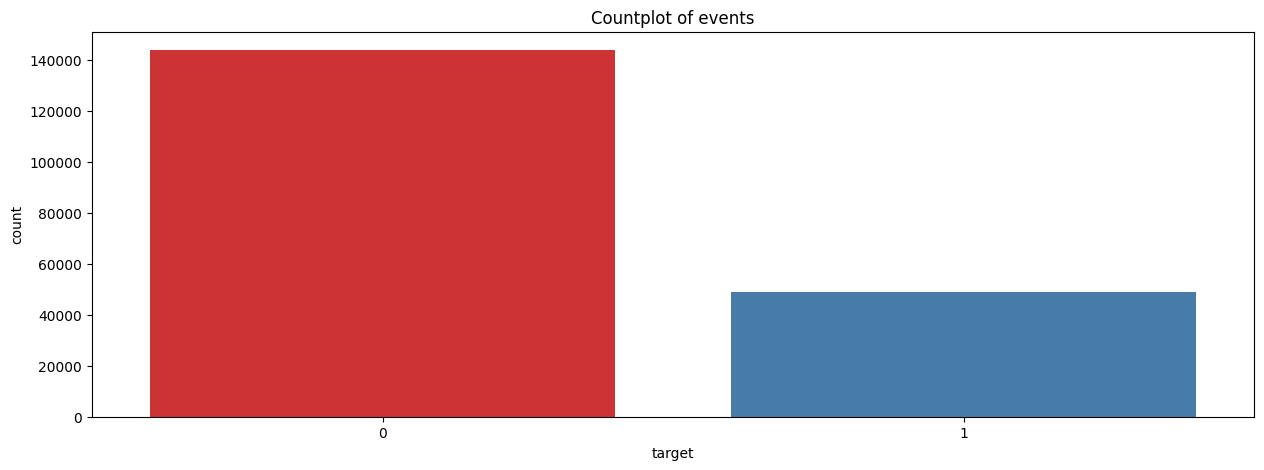

In [75]:
np.float = float
sns.countplot(x='target', data=dataset, palette='Set1').set(title = "Countplot of events")

Text(0, 0.5, 'Number of Air alerts')

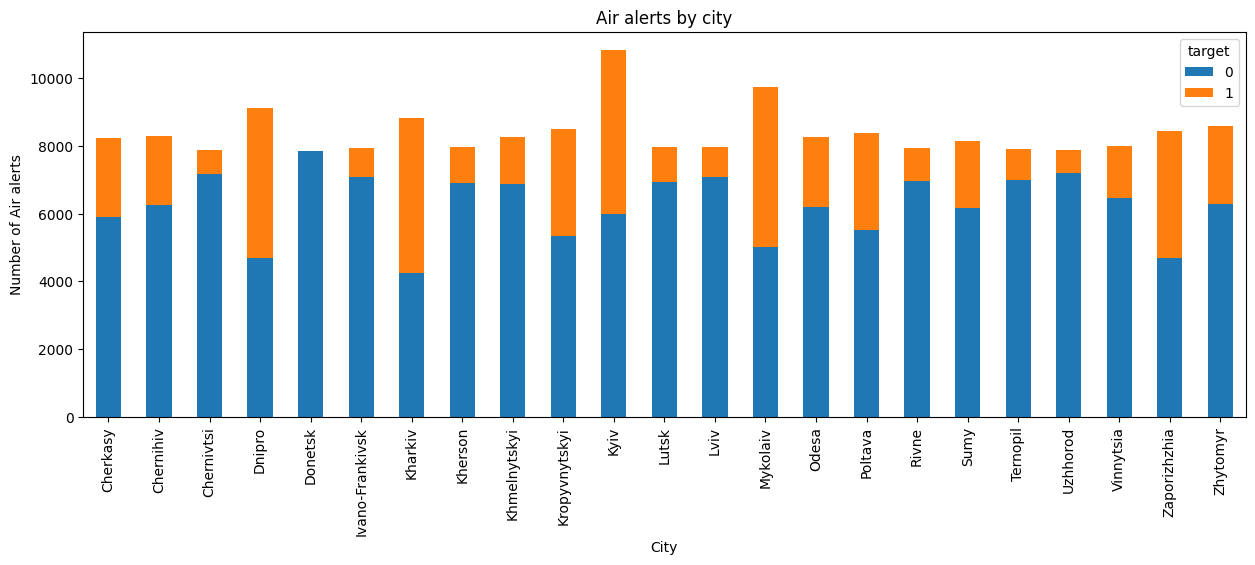

In [76]:
#%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 5]
pd.crosstab(dataset['city'], dataset['target']).plot(kind='bar', stacked=True)
plt.title('Air alerts by city')
plt.xlabel('City')
plt.ylabel('Number of Air alerts')

In [77]:
# Create id column for each unique city
cities = dataset['city'].unique()
city_dict = {cities[i]: i+1 for i in range(len(cities))}
dataset['city_id'] = dataset['city'].map(city_dict)
dataset.drop('city', axis=1, inplace=True)

city_dict

{'Lutsk': 1,
 'Zhytomyr': 2,
 'Rivne': 3,
 'Poltava': 4,
 'Ternopil': 5,
 'Uzhhorod': 6,
 'Donetsk': 7,
 'Zaporizhzhia': 8,
 'Sumy': 9,
 'Cherkasy': 10,
 'Vinnytsia': 11,
 'Lviv': 12,
 'Ivano-Frankivsk': 13,
 'Kherson': 14,
 'Kyiv': 15,
 'Dnipro': 16,
 'Chernivtsi': 17,
 'Kropyvnytskyi': 18,
 'Kharkiv': 19,
 'Mykolaiv': 20,
 'Khmelnytskyi': 21,
 'Odesa': 22,
 'Chernihiv': 23}

# Model Selection

In [54]:
models = {}

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(random_state=5, class_weight="balanced", verbose=True)

# Support Vector Machines - Poor performance
# from sklearn.svm import SVC
# models['Support Vector Machines'] = SVC(random_state=5, class_weight="balanced", verbose=True)

# Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
models['Stochastic Gradient Descent'] = SGDClassifier(random_state=5, class_weight="balanced", loss="log", verbose=True)

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier(random_state=5, class_weight="balanced", verbose=True)

# AdaBoost
from sklearn.ensemble import AdaBoostClassifier
models['AdaBoost'] = AdaBoostClassifier(random_state=5)


# XGBoost
from xgboost import XGBClassifier
models['XGBoost'] = XGBClassifier(random_state=5, objective='binary:logistic', booster='gbtree', verbose=2)

# k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['KNN'] = KNeighborsClassifier(n_neighbors=7)

In [55]:
models

{'Logistic Regression': LogisticRegression(class_weight='balanced', random_state=5, verbose=True),
 'Stochastic Gradient Descent': SGDClassifier(class_weight='balanced', loss='log', random_state=5, verbose=True),
 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=5, verbose=True),
 'AdaBoost': AdaBoostClassifier(random_state=5),
 'XGBoost': XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constr

In [56]:
# Save the models to disk
for model_name in models.keys():
    filename = f'model/6__{model_name}__v0.pkl'
    pickle.dump(models[model_name], open(filename, 'wb'))
    print(f"{filename} saved")

model/6__Logistic Regression__v0.pkl saved
model/6__Stochastic Gradient Descent__v0.pkl saved
model/6__Random Forest__v0.pkl saved
model/6__AdaBoost__v0.pkl saved
model/6__XGBoost__v0.pkl saved
model/6__KNN__v0.pkl saved


# Model Training

In [57]:
min_date = dataset['day_datetime'].min()
max_date = dataset['day_datetime'].max()
print("Min:", min_date, "Max:", max_date)

Min: 2022-02-25 00:00:00 Max: 2023-01-20 00:00:00


In [58]:
train_percent = .75
time_between = max_date - min_date
train_cutoff = min_date + train_percent*time_between
train_cutoff

Timestamp('2022-10-29 18:00:00')

In [59]:
train_df = dataset[dataset['day_datetime'] <= train_cutoff]
test_df = dataset[dataset['day_datetime'] > train_cutoff]

In [60]:
# Split the dataset into features (X) and target (y)
X_train, X_test = train_df.drop(columns=['target', 'day_datetime']), test_df.drop(columns=['target', 'day_datetime'])
y_train, y_test = train_df['target'], test_df['target']

X_train.shape

(147734, 765)

In [25]:
# Train models
predict_dict, predict_proba_dict = {}, {}

for key in models.keys():
    print(key)

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predict_dict[key] = models[key].predict(X_test)
    predict_proba_dict[key] = models[key].predict_proba(X_test)[:, 1]

Logistic Regression


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
c:\Users\tmyro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.5s finished


Stochastic Gradient Descent


c:\Users\tmyro\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


-- Epoch 1
Norm: 6929.51, NNZs: 765, Bias: 2.531528, T: 147734, Avg. loss: 487935.249065
Total training time: 0.34 seconds.
-- Epoch 2
Norm: 5576.99, NNZs: 765, Bias: 2.582501, T: 295468, Avg. loss: 60022.949721
Total training time: 0.65 seconds.
-- Epoch 3
Norm: 4821.55, NNZs: 765, Bias: 2.544275, T: 443202, Avg. loss: 33365.054058
Total training time: 0.94 seconds.
-- Epoch 4
Norm: 4382.28, NNZs: 765, Bias: 2.583476, T: 590936, Avg. loss: 23120.880702
Total training time: 1.24 seconds.
-- Epoch 5
Norm: 4083.93, NNZs: 765, Bias: 2.571382, T: 738670, Avg. loss: 17453.024764
Total training time: 1.57 seconds.
-- Epoch 6
Norm: 3865.25, NNZs: 765, Bias: 2.574179, T: 886404, Avg. loss: 14016.597864
Total training time: 1.88 seconds.
-- Epoch 7
Norm: 3700.33, NNZs: 765, Bias: 2.572445, T: 1034138, Avg. loss: 11616.278014
Total training time: 2.17 seconds.
-- Epoch 8
Norm: 3567.67, NNZs: 765, Bias: 2.565379, T: 1181872, Avg. loss: 9870.576436
Total training time: 2.50 seconds.
-- Epoch 9
Nor

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


AdaBoost
XGBoost
[22:18:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "verbose" } are not used.

KNN


# Model Evaluation

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from scikitplot.helpers import binary_ks_curve
from sklearn.metrics import matthews_corrcoef

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [30]:
accuracy, precision, recall, f1, auc, pr_auc, loss, b_loss, ks_stat, matthews_corr = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

for key in models.keys():
    
    # Calculate metrics
    accuracy[key] = accuracy_score(y_test, predict_dict[key])
    precision[key] = precision_score(y_test, predict_dict[key])
    recall[key] = recall_score(y_test, predict_dict[key])
    f1[key] = f1_score(y_test, predict_dict[key])
    auc[key] = roc_auc_score(y_test, predict_proba_dict[key])
    pr_auc[key] = average_precision_score(y_test, predict_proba_dict[key])
    loss[key] = log_loss(y_test, predict_proba_dict[key])
    b_loss[key] = brier_score_loss(y_test, predict_proba_dict[key])
    ks_stat[key] =  binary_ks_curve(y_test, predict_proba_dict[key])[3]
    matthews_corr[key] = matthews_corrcoef(y_test, predict_dict[key])
    
columns=['Accuracy', 'Precision', 'Recall', 'F1', 'ROC AUC', 'PR AUC', 'Log loss', 'Brier score', 'KS', 'MCC']   
df_model = pd.DataFrame(index=models.keys(), columns=columns)

df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['F1'] = f1.values()
df_model['ROC AUC'] = auc.values()
df_model['PR AUC'] = pr_auc.values()
df_model['Log loss'] = loss.values()
df_model['Brier score'] = b_loss.values()
df_model['KS'] = ks_stat.values()
df_model['MCC'] = matthews_corr.values()

df_model

,Accuracy,Precision,Recall,F1,ROC AUC,PR AUC,Log loss,Brier score,KS,MCC
Logistic Regression,0.865930,0.570466,0.646438,0.606080,0.892680,0.625451,0.311503,0.095087,0.665284,0.527169
Stochastic Gradient Descent,0.845678,0.509442,0.884183,0.646429,0.888763,0.521183,5.091529,0.153696,0.723021,0.591297
Random Forest,0.842621,0.818182,0.017498,0.034262,0.930659,0.724388,0.304632,0.090667,0.782775,0.105243
AdaBoost,0.920036,0.754391,0.739619,0.746932,0.956586,0.838153,0.640472,0.223718,0.844097,0.699502
XGBoost,0.915827,0.774443,0.666574,0.716471,0.960514,0.798984,0.314316,0.071242,0.828378,0.669962
KNN,0.799703,0.350658,0.299819,0.323252,0.680382,0.274307,2.004754,0.147760,0.299801,0.207423


Confusion matrix for Logistic Regression


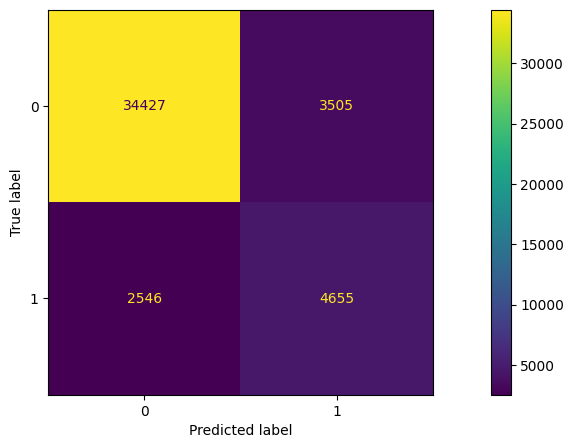

Confusion matrix for Stochastic Gradient Descent


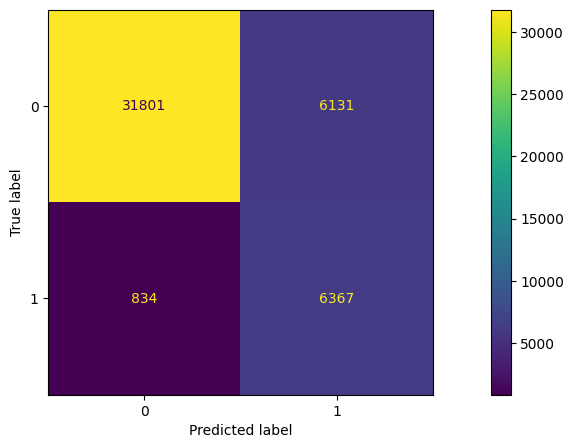

Confusion matrix for Random Forest


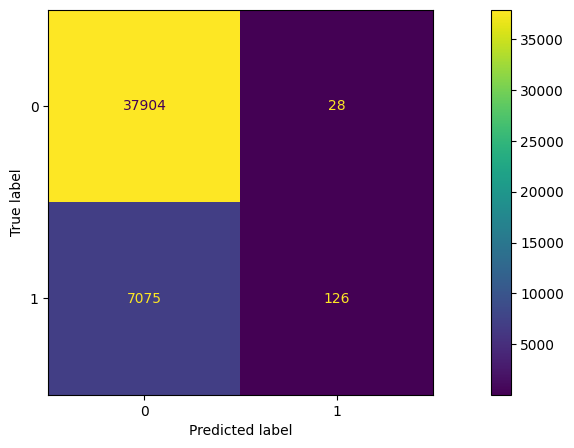

Confusion matrix for AdaBoost


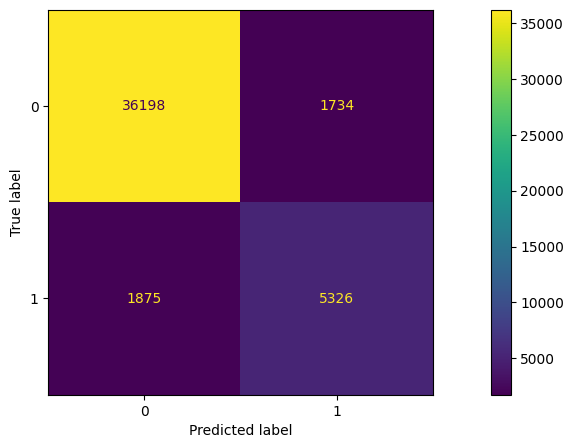

Confusion matrix for XGBoost


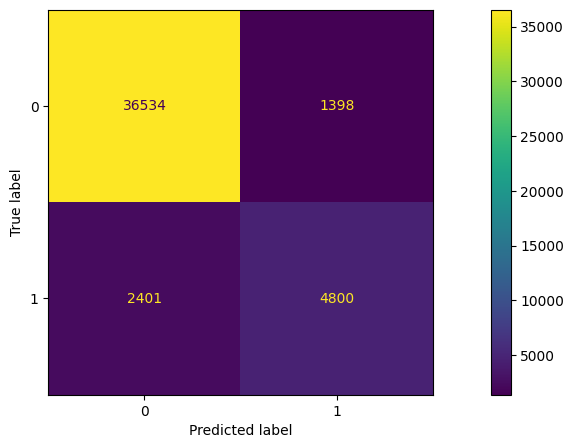

Confusion matrix for KNN


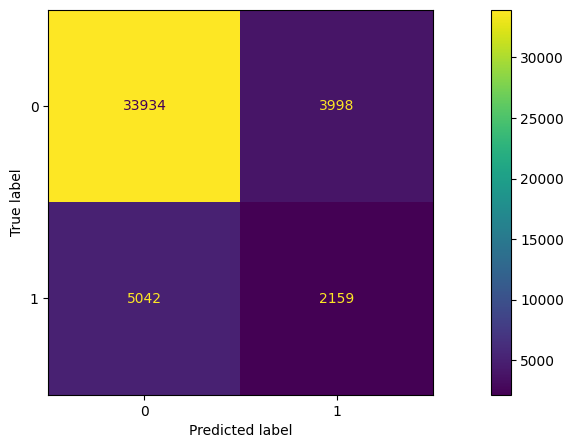

In [31]:
# Generate confusion matrix plots
for key in models.keys():
    print(f"Confusion matrix for {key}")
    
    matrix = confusion_matrix(y_test, predict_dict[key])
    cm = confusion_matrix(y_test, predict_dict[key], labels=models[key].classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=models[key].classes_)
    disp.plot()
    plt.show()

In [32]:
for key in models.keys():
    print(f"Classification report for {key}")
    print(classification_report(y_test, predict_dict[key]))
    print("=====================================================")

Classification report for Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     37932
           1       0.57      0.65      0.61      7201

    accuracy                           0.87     45133
   macro avg       0.75      0.78      0.76     45133
weighted avg       0.87      0.87      0.87     45133

Classification report for Stochastic Gradient Descent
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     37932
           1       0.51      0.88      0.65      7201

    accuracy                           0.85     45133
   macro avg       0.74      0.86      0.77     45133
weighted avg       0.90      0.85      0.86     45133

Classification report for Random Forest
              precision    recall  f1-score   support

           0       0.84      1.00      0.91     37932
           1       0.82      0.02      0.03      7201

    accuracy                           0.8

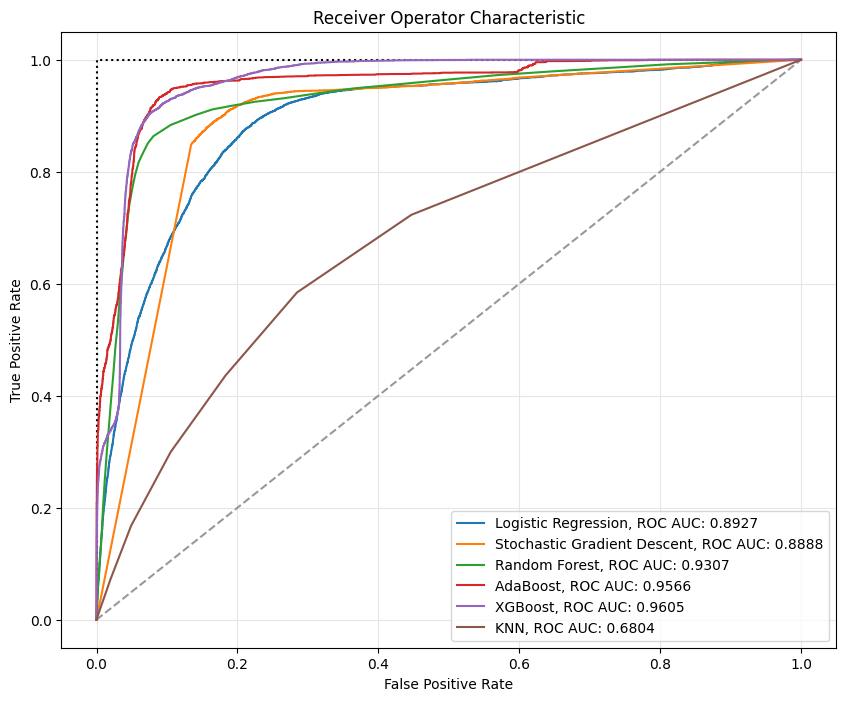

In [33]:
# ROC curves
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#set up plotting area
plt.rcParams["figure.figsize"] = [10, 8]
plt.figure(0).clf()

# roc curve for random and perfect models
plt.plot([0, 1], [0, 1], linestyle = '--', color = (0.6, 0.6, 0.6))
plt.plot([0, 0, 1], [0, 1, 1], linestyle = ':', color = 'black')

for key in models.keys():
    fpr, tpr, thresholds = roc_curve(y_test, predict_proba_dict[key])
    auc = round(roc_auc_score(y_test, predict_proba_dict[key]), 4)
    plt.plot(fpr, tpr, label=f"{key}, ROC AUC: {auc}")
 

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operator Characteristic')
plt.grid(color='0.9')
plt.legend()

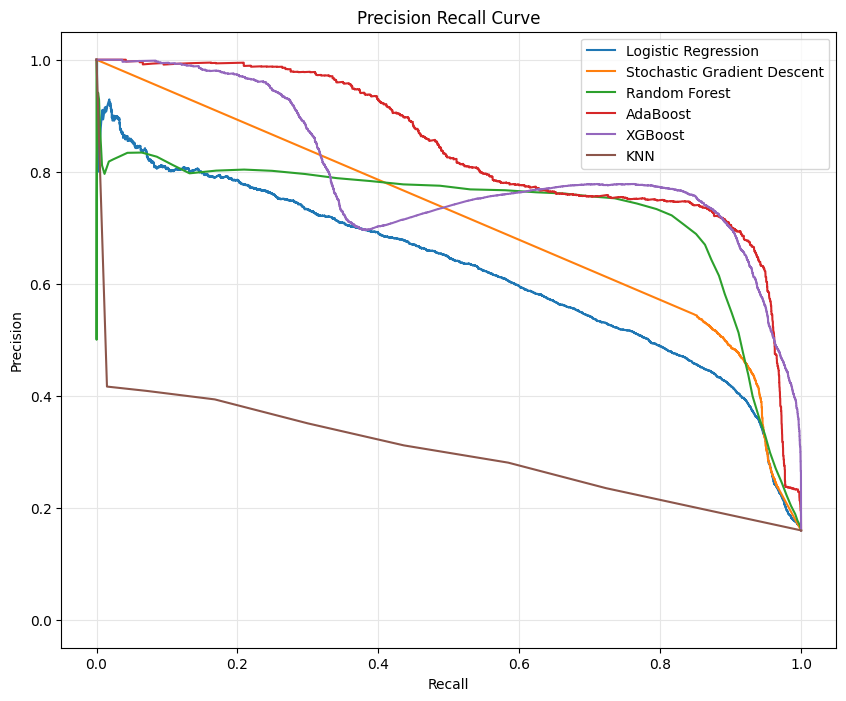

In [34]:
# Precision Recall Curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

#set up plotting area
plt.figure(0).clf()

for key in models.keys():
    precision, recall, thresholds = precision_recall_curve(y_test, predict_proba_dict[key])
    label = f'{key}'
    plt.plot(recall, precision, label = label)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('Recall')  
plt.ylabel('Precision')  
plt.title('Precision Recall Curve')
plt.grid(color='0.9')
plt.legend()

In [36]:
for key in models.keys():
    with open(f"model/6__{key}__v2.pkl", 'wb') as handle:
        pickle.dump(models[key], handle)